In [1]:
import menpo.io as mio
from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh

path_to_images = '/home/rshaydu/tensorfaces/helen/trainset/'
training_images = []
for img in print_progress(mio.import_images(path_to_images, verbose=True)):
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    # append to list
    training_images.append(img)



Found 2000 assets, index the returned LazyList to import.
[====================] 100% (2000/2000) - done.                                 


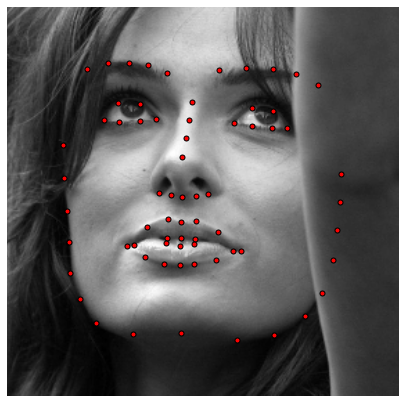

In [2]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(training_images)

In [3]:
from menpofit.aam import HolisticAAM
from menpo.feature import fast_dsift

aam = HolisticAAM(training_images, group='face_ibug_68_trimesh', diagonal=150,
                  scales=(0.5, 1.0), holistic_features=fast_dsift, verbose=True,
                  max_shape_components=20, max_appearance_components=150)


- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (2000/2000) - done.                
  - Scale 0: Doneding appearance model                                          maining
  - Scale 1: Doneding appearance model                                          
                                                              

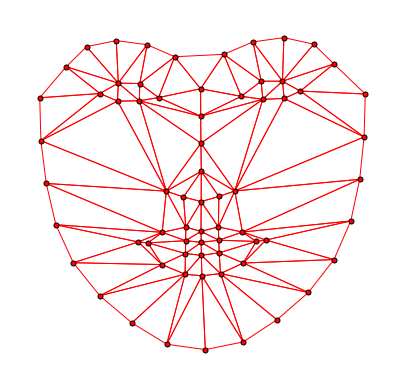

In [4]:
aam.view_shape_models_widget()

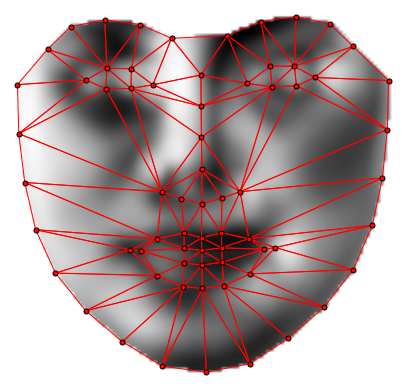

In [5]:
aam.view_appearance_models_widget()

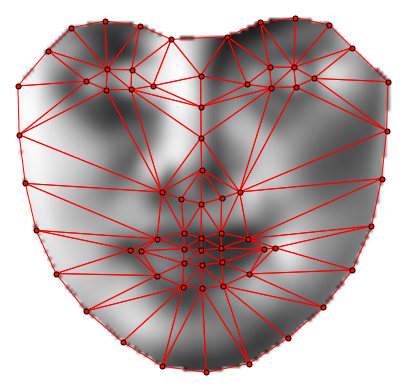

In [6]:
aam.view_aam_widget()

In [7]:
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift

patch_aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)


- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (2000/2000) - done.                
  - Scale 0: Doneding appearance model                                          ngining
  - Scale 1: Doneding appearance model                                          ng
                                                              

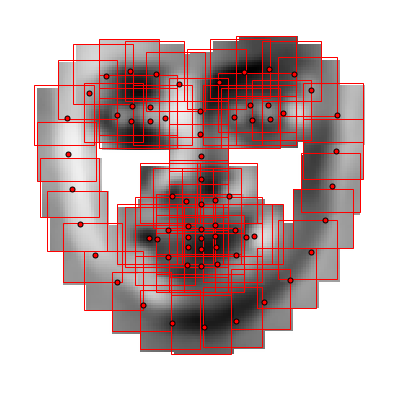

In [8]:
patch_aam.view_appearance_models_widget()

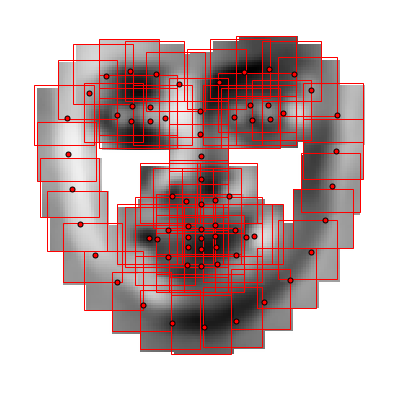

In [9]:
patch_aam.view_aam_widget()

In [10]:
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional

fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])


In [11]:
print(fitter)

Patch-based Active Appearance Model
 - Images scaled to diagonal: 150.00
 - No image warping performed
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 150 appearance components
     - Shape model class: OrthoPDM
       - 20 shape components
       - 4 similarity transform parameters
     - Patch shape: (15, 15)
   - Scale 1.0
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 150 appearance components
     - Shape model class: OrthoPDM
       - 20 shape components
       - 4 similarity transform parameters
     - Patch shape: (23, 23)
Wiberg Inverse Compositional Algorithm
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - 5 active shape components
     - 4 similarity transform components
     - 30 active appearance components
   - Scale 1.0
     - 20 active shape components
     - 4 similarity transform components
     - 150 active appearance components
    


In [12]:
from pathlib import Path
import menpo.io as mio

path_to_lfpw = Path('/home/rshaydu/tensorfaces/helen/testset/')

image = mio.import_image(path_to_lfpw / '296814969_3.jpg')
image = image.as_greyscale()


1 detected faces.


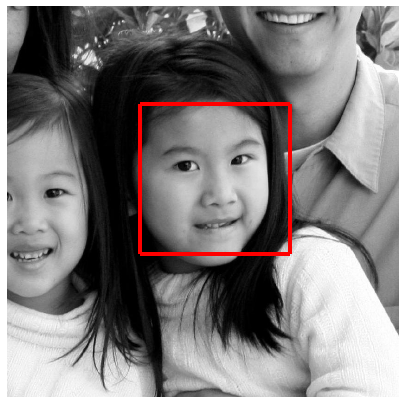

In [13]:
from menpodetect import load_opencv_frontal_face_detector

# Load detector
detect = load_opencv_frontal_face_detector()

# Detect
bboxes = detect(image)
print("{} detected faces.".format(len(bboxes)))

# View
if len(bboxes) > 0:
    image.view_landmarks(group='opencv_0', line_colour='red',
                         render_markers=False, line_width=4);

In [14]:
# initial bbox
initial_bbox = bboxes[0]

# fit image
result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15, 5],
                            gt_shape=image.landmarks['PTS'])

# print result
print(result)

Fitting result of 68 landmark points.
Initial error: 0.2142
Reconstructed initial error: 0.2142
Final error: 0.0156


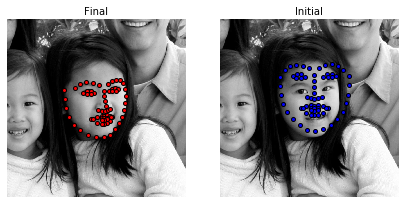

In [15]:
result.view(render_initial_shape=True)

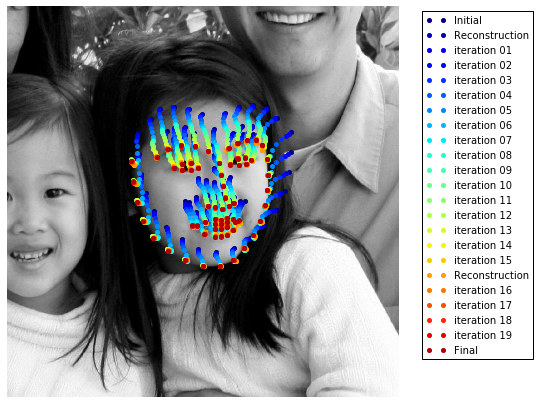

In [16]:
result.view_iterations()

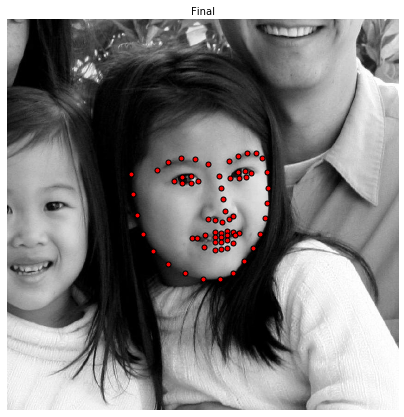

In [17]:
result.view_widget()

In [18]:
# from menpodetect import load_ffld2_frontal_face_detector

# # Load detector
# detect = load_ffld2_frontal_face_detector()

# # Detect
# bboxes = detect(image)
# print("{} detected faces.".format(len(bboxes)))

# # View
# if len(bboxes) > 0:
#     image.view_landmarks(group='llfd2_0', line_colour='red',
#                          render_markers=False, line_width=4);

In [63]:
import matplotlib.pyplot as plt
from menpodetect import load_opencv_frontal_face_detector


# Load and convert to grayscale
image = mio.import_image('/home/rshaydu/tensorfaces/FaceBase_png/yaron-vp1-il1-ex2.png')
image = image.as_greyscale()

# Load detector
detect = load_opencv_frontal_face_detector()

# Detect face
bboxes = detect(image,min_size=(300, 300))
if len(bboxes) > 0:
    image.view_landmarks(group='opencv_0', line_colour='red',
                         render_markers=False, line_width=4);
else:
    print("Error: no faces detected")

Error: no faces detected


In [74]:
import numpy as np
import menpo

# initial bbox
# build box by hand
adjacency_matrix = np.array([[0,1,0,0],
                             [0,0,1,0],
                             [0,0,0,1],
                             [1,0,0,0]])
points = np.array([[50,100],[350,100],[350,400],[50,400]])
initial_bbox = menpo.shape.PointDirectedGraph(points, adjacency_matrix)

# fit image
result = fitter.fit_from_bb(image, initial_bbox, max_iters=50)

# print result
print(result)


Fitting result of 68 landmark points.


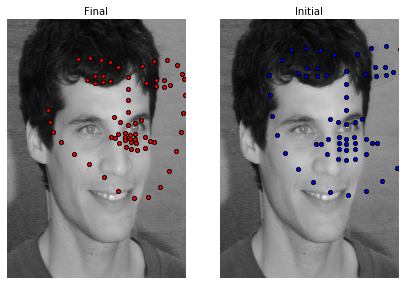

In [75]:
result.view(render_initial_shape=True)

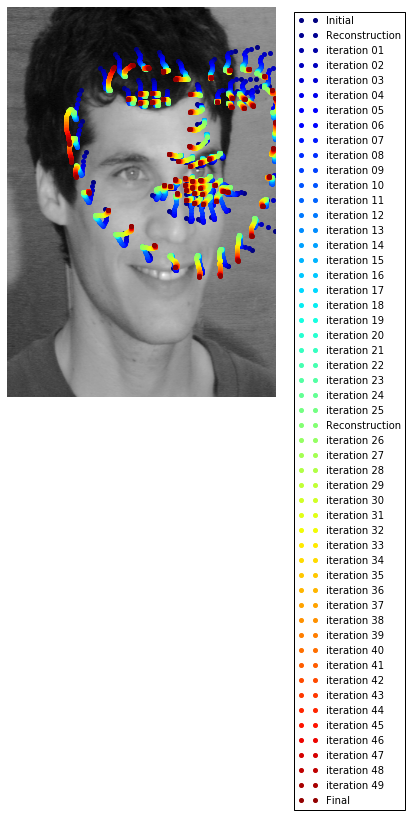

In [76]:
result.view_iterations()